# Embedding space examination

- pip install numpy
- pip install pandas
- pip install scipy
- pip install librosa
- pwd

In [1]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np
import pandas as pd
import tensorflow as tf
import csv

from scipy.spatial import cKDTree

import IPython

/opt/conda/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/pytho

In [2]:
experiment_path = "/home/jovyan/work/experiments/DCASE/results/ResNet18-LogMel-l1e5-d95-7500-b64-l2001-ts5-ns5-m1-e256-20200511-155329/tensorboard/"
embeddings_path = experiment_path + "embeddings.tsv"
labels_path = experiment_path + "labels.tsv"
names_path = experiment_path + "names.tsv"

dataset_path = "/home/jovyan/work/data/DCASE18-Task5-development/audio/"

In [3]:
embedding_space = []
with open(embeddings_path,'r') as tsvin:
    for line in csv.reader(tsvin, delimiter='\n'):
        embedding = []
        for value in csv.reader(line, delimiter='\t'):
            value = value[:-1]
            for v in value:
                embedding.append(v)
        embedding_space.append(np.asarray(embedding))

        if len(embedding_space) >= 100000:
            break

embedding_space = np.asarray(embedding_space)
embedding_space.shape

(36048, 256)

In [4]:
embedding_space_metadata = []
with open(labels_path,'r') as tsvin_labels:
    with open(names_path,'r') as tsvin_names:
        for line_label, line_name in zip(csv.reader(tsvin_labels, delimiter='\n'), csv.reader(tsvin_names, delimiter='\n')):
            embedding_space_metadata.append(np.asarray(np.concatenate((line_label, line_name), axis=0)))

            if len(embedding_space_metadata) >= 100000:
                break

embedding_space_metadata = np.asarray(embedding_space_metadata)
embedding_space_metadata.shape

(36048, 2)

In [5]:
def get_duplicate_indices(embedding_names):
    oc_set = set() 
    res = [] 
    for idx, val in enumerate(embedding_names): 
        if val not in oc_set: 
            oc_set.add(val)          
        else: 
            res.append(idx)
    return res

In [6]:
def build_neighbouring_tree(embedding_space):
    tree = cKDTree(embedding_space)
    return tree

In [11]:
def check_neighbourhood(id):
    K = 20
    result = tree.query(embedding_space[id], k=K)
    distances, indices = result
    labels_neighbours = np.take(embedding_space_metadata[:, 0], indices)
    names_neighbours = np.take(embedding_space_metadata[:, 1], indices)
    
    # remove duplicates
    duplicate_indices = get_duplicate_indices(names_neighbours)
    labels_neighbours = np.delete(labels_neighbours, duplicate_indices)
    names_neighbours = np.delete(names_neighbours, duplicate_indices)
    
    unequal_labels = (labels_neighbours != [embedding_space_metadata[id][0]]).sum()
    
    return unequal_labels, labels_neighbours, names_neighbours

In [35]:
def check_neighbour_from_embed(embed):
    K = 5
    result = tree.query(embed, k=K)
    distances, indices = result
    labels_neighbours = np.take(embedding_space_metadata[:, 0], indices)
    names_neighbours = np.take(embedding_space_metadata[:, 1], indices)
    
    # remove duplicates
    duplicate_indices = get_duplicate_indices(names_neighbours)
    labels_neighbours = np.delete(labels_neighbours, duplicate_indices)
    names_neighbours = np.delete(names_neighbours, duplicate_indices)
    
    return labels_neighbours, names_neighbours

## Build the neighbouring tree

In [9]:
tree = build_neighbouring_tree(embedding_space)
tree

## Examine wrong classified segments

In [13]:
anchor_id = np.random.randint(low = 0, high = len(embedding_space), size = 1)[0] 
unequal_labels, labels_neighbours, names_neighbours = check_neighbourhood(anchor_id)
while unequal_labels < 19:
    anchor_id = np.random.randint(low = 0, high = len(embedding_space), size = 1)[0] 
    unequal_labels, labels_neighbours, names_neighbours = check_neighbourhood(anchor_id)
print("Examine id: {}".format(anchor_id))
print("Unequal labels: {}".format(unequal_labels))
print("Label from anchor id {0}: label: {1}, name: {2}".format(anchor_id, embedding_space_metadata[anchor_id][0], embedding_space_metadata[anchor_id][1]))
print("Labels from neighbours: {}".format(str(labels_neighbours)))

Examine id: 21362
Unequal labels: 19
Label from anchor id 21362: label: absence, name: DevNode4_ex11_496
Labels from neighbours: ['absence' 'working' 'working' 'working' 'working' 'working' 'working'
 'working' 'working' 'working' 'working' 'working' 'working' 'working'
 'working' 'working' 'working' 'working' 'working' 'working']


In [ ]:
# play anchor sound
print(embedding_space_metadata[anchor_id][1])
print(embedding_space_metadata[anchor_id][0])
IPython.display.Audio(dataset_path + embedding_space_metadata[anchor_id][1] + ".wav")

In [ ]:
# play neighbour sound
print(names_neighbours[1])
print(labels_neighbours[1])
IPython.display.Audio(dataset_path + names_neighbours[1] + ".wav")

Missclassified:
- anchor: DevNode4_ex267_150 (working)
- neighbours: DevNode4_ex11_79 (absence)
- DevNode4_ex242_10 (working -> absence)

## Examine walk through embedding space

In [40]:
from_label = "eating"
to_label = "cooking"

from_embed_arr = []
from_embed = None

to_embed_arr = []
to_embed = None

for i, (emb, meta) in enumerate(zip(embedding_space, embedding_space_metadata)):
    if meta[0] == from_label and from_embed is None:
        unequal_labels, labels_neighbours, names_neighbours = check_neighbourhood(i)
        if unequal_labels == 0:
            from_embed_arr.append(emb)
    elif meta[0] == to_label and to_embed is None:
        unequal_labels, labels_neighbours, names_neighbours = check_neighbourhood(i)
        if unequal_labels == 0:
            to_embed_arr.append(emb)

In [41]:
from_embed_arr = np.asarray(from_embed_arr)
from_embed_arr = from_embed_arr.astype(float)
from_embed = np.mean(from_embed_arr, axis = 0)

to_embed_arr = np.asarray(to_embed_arr)
to_embed_arr = to_embed_arr.astype(float)
to_embed = np.mean(to_embed_arr, axis = 0)

In [42]:
difference_emb = to_embed - from_embed
difference_step = difference_emb / 10
labels_neighbours, names_neighbours = check_neighbour_from_embed(difference_emb)
labels_neighbours

array(['cooking', 'cooking', 'cooking', 'cooking'], dtype='<U18')

['absence' 'absence' 'eating' 'absence' 'absence']
['DevNode3_ex11_543' 'DevNode3_ex11_65' 'DevNode3_ex68_28'
 'DevNode3_ex11_539' 'DevNode3_ex11_545']


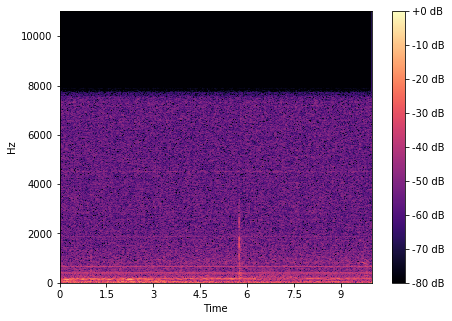

['absence' 'absence' 'eating' 'absence' 'absence']
['DevNode3_ex11_543' 'DevNode3_ex11_65' 'DevNode3_ex68_28'
 'DevNode3_ex11_545' 'DevNode3_ex11_539']


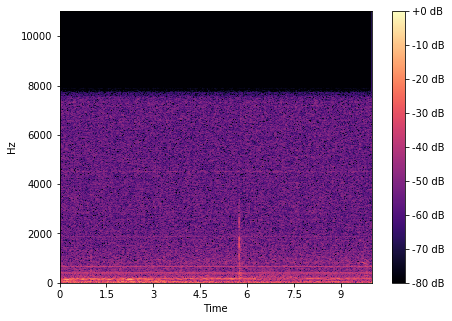

['absence' 'absence' 'eating' 'eating' 'eating']
['DevNode3_ex11_543' 'DevNode3_ex11_65' 'DevNode3_ex68_28'
 'DevNode3_ex68_25' 'DevNode3_ex68_1']


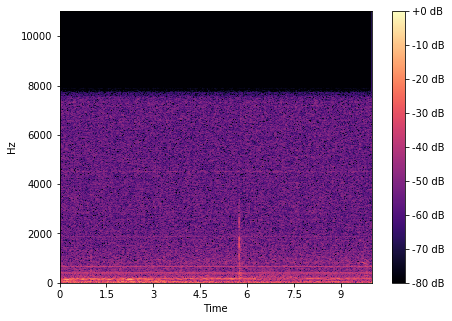

['eating' 'absence' 'absence' 'eating' 'absence']
['DevNode3_ex68_1' 'DevNode3_ex11_546' 'DevNode3_ex11_543'
 'DevNode3_ex68_25' 'DevNode3_ex11_65']


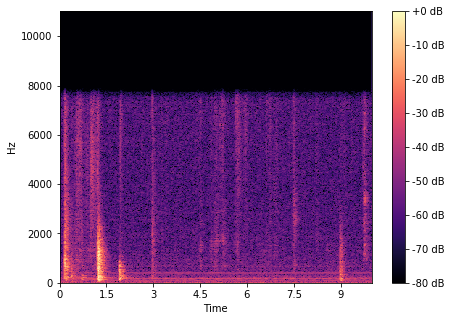

['eating' 'dishwashing' 'dishwashing' 'absence' 'dishwashing']
['DevNode3_ex68_1' 'DevNode3_ex57_1' 'DevNode1_ex57_23'
 'DevNode3_ex11_546' 'DevNode3_ex57_23']


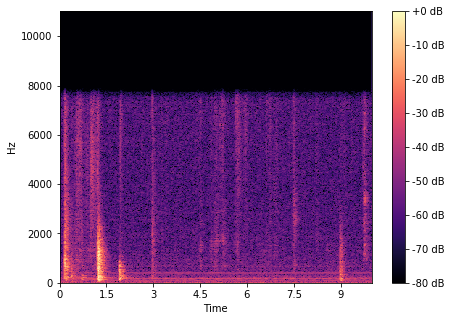

['dishwashing' 'dishwashing' 'cooking' 'dishwashing' 'dishwashing']
['DevNode3_ex57_23' 'DevNode1_ex57_23' 'DevNode3_ex50_36'
 'DevNode3_ex57_1' 'DevNode3_ex57_12']


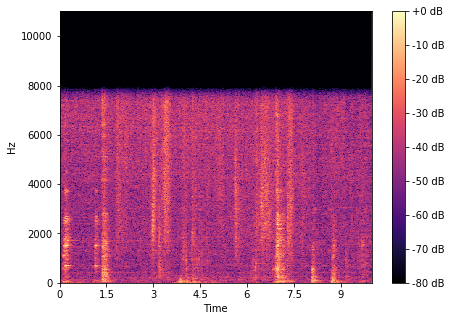

['dishwashing' 'dishwashing' 'cooking' 'cooking' 'cooking']
['DevNode3_ex57_23' 'DevNode3_ex57_1' 'DevNode3_ex50_36' 'DevNode3_ex54_7'
 'DevNode3_ex54_8']


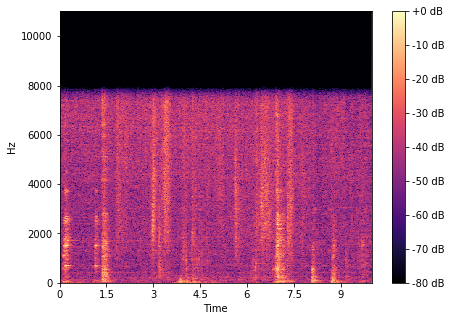

['dishwashing' 'cooking' 'cooking' 'cooking' 'dishwashing']
['DevNode3_ex57_23' 'DevNode3_ex54_7' 'DevNode3_ex54_8' 'DevNode3_ex54_11'
 'DevNode3_ex57_1']


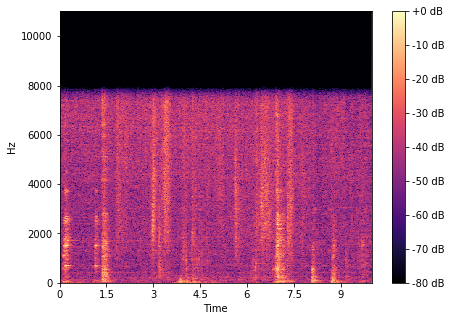

['dishwashing' 'cooking' 'cooking' 'cooking' 'dishwashing']
['DevNode3_ex57_23' 'DevNode3_ex54_7' 'DevNode3_ex54_11' 'DevNode3_ex54_8'
 'DevNode3_ex57_1']


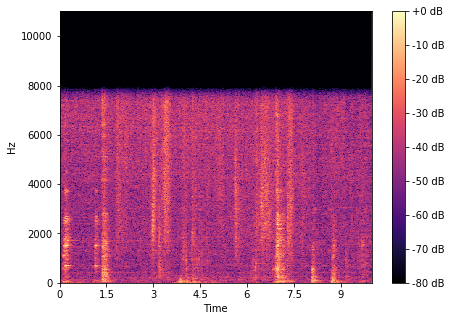

['cooking' 'cooking' 'dishwashing' 'cooking' 'cooking']
['DevNode3_ex54_7' 'DevNode3_ex54_11' 'DevNode3_ex57_23' 'DevNode3_ex54_8'
 'DevNode3_ex54_119']


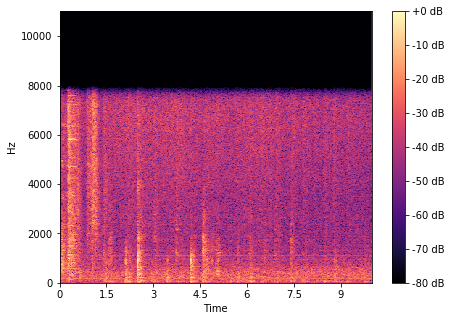

In [43]:
for i in range(10):
    embed = from_embed + difference_step * i
    labels_neighbours, names_neighbours = check_neighbour_from_embed(embed)
    print(labels_neighbours)
    print(names_neighbours)
    
    y, sr = librosa.load(dataset_path + names_neighbours[0] + ".wav")
    D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
    plt.figure(figsize=(7, 5))
    librosa.display.specshow(D, y_axis='linear', x_axis='time')

    clb = plt.colorbar(format='%+2.0f dB')
    plt.show()